In [15]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join as jn
import yaml
import torch_sensor_lib as tsl

import torch
from torchsummary import summary
from tqdm import tqdm
from torch.utils.data import DataLoader
import os
import pandas as pd

In [16]:
with open('params.yaml') as conf_file:
    config = yaml.safe_load(conf_file)

torch.manual_seed(config['random_seed'])
np.random.seed(config['random_seed'])
seeds = np.random.randint(0, 2**31, size=3)
model = torch.load(jn(config['train']['models_path'], config['train']['model_name'] + '.pt'))
model.eval()
out_path = config['evaluate']['reports_path']

In [17]:
class DataSet():

    def __init__(self, input_path, output_path):
        self.input_path = input_path
        self.output_path = output_path
        self.file_names = os.listdir(input_path)
        self.i = 0

    def __iter__(self):
        self.i = 0
        return self
    
    def __len__(self):
        return self.file_names.__len__()

    def __next__(self):
        if self.i >= len(self.file_names):
            raise StopIteration
        else:
            res = torch.from_numpy(np.load(jn(self.input_path,
                             self.file_names[self.i]))), \
                  torch.from_numpy(np.load(jn(output_path,
                             self.file_names[self.i])))
            self.i += 1
            return res

    def __getitem__(self, index):
        return np.load(jn(self.input_path, self.file_names[index])), np.load(
            jn(output_path, self.file_names[index]))



input_path = config['dataset']['signal_path']
output_path = config['dataset']['pic_path']

test_dataloader = DataSet(jn(input_path, 'test'), output_path)

In [18]:
if not torch.cuda.is_available():
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = 'cuda' if torch.cuda.is_available() else 'cpu'


CUDA is not available.  Training on CPU ...


In [19]:
report = open(jn(out_path, 'report.md'), 'w')
print(f"# Report about training model **{config['train']['model_name']}**", file=report)
print(f"## Architecture summary\n```\n", file=report)
print(model, file=report)
print('\n```', file=report)

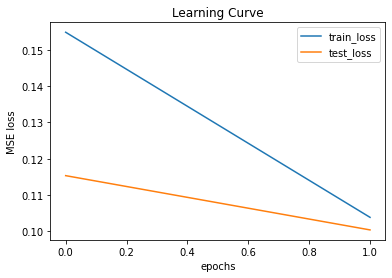

In [20]:
curve = pd.read_csv(jn(out_path, 'learning_curve.csv'))
curve.plot()
plt.title("Learning Curve")
plt.xlabel("epochs")
plt.ylabel("MSE loss")
plt.savefig(jn(out_path, 'l_curve.png'), dpi=200)
print("![learning curve](l_curve.png)", file=report)

## Отображение разных примеров предсказания

In [21]:
# training functions

def picturewise_loss_and_predict(model, data_loader, criterion):
    losses = []
    result = []


    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        losses.append(torch.mean(criterion(outputs, labels), dim=(-1, -2)).cpu().numpy())
        result.append(outputs.cpu().numpy())
    return np.concatenate(losses), np.concatenate(result)



In [22]:
losses, pred_pic = picturewise_loss_and_predict(model, test_dataloader, torch.nn.MSELoss(reduction='none'))
pred_pic.shape, losses.shape

((512, 64, 64), (512,))

In [23]:
best_ind = losses.argmin()
worst_ind = losses.argmax()
rand_ind1 = np.random.randint(len(losses))
rand_ind2 = np.random.randint(len(losses))
indexes = [best_ind, rand_ind1, rand_ind2, worst_ind]
sample_titles = ["best", "random", "random", "worst"]
y_titles = ["true", "predict", "signal"]


In [24]:
import torch_sensor_lib as tsl

In [25]:
s = tsl.FiberSimulator(config, device='cpu')
config['env']['phys']['noise'] = 0
config['env']['phys']['relative_noise'] = 0
# TODO remove signal noise here
data = []
for ind in indexes:
    data.append([])
    double_ind = np.unravel_index(ind, (len(test_dataloader), len(losses)//len(test_dataloader)))
    signal, pic = test_dataloader[double_ind[0]]
    signal, pic = signal[double_ind[1]], pic[double_ind[1]]
    data[-1].append(pic)
    data[-1].append(pred_pic[ind])
    true_signal = signal[0]
    pred_signal = s._sum_fiber_losses(torch.from_numpy(pred_pic[ind:ind+1]))[0].numpy()
    data[-1].append(np.concatenate([true_signal.reshape(-1, 1), pred_signal.reshape(-1, 1)], axis=1))
    

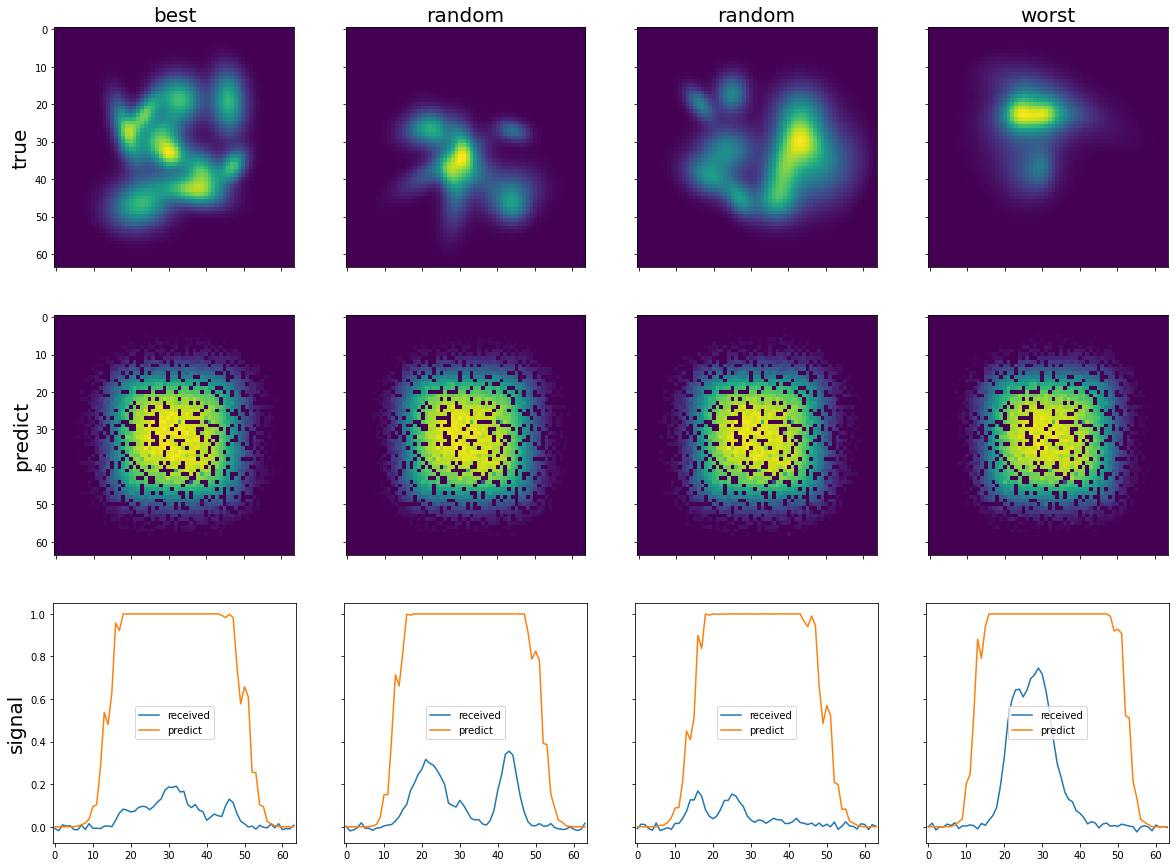

In [26]:
visual_func = [lambda ax, pic: ax.imshow(pic)]*2 + [lambda ax, pic: (ax.plot(pic, label=['received', 'predict']), ax.legend(loc="best"))]
tsl.visual_table_of_pictures(data, sample_titles, y_titles, visual_func)
plt.savefig(jn(out_path, 'predict_examples.png'), dpi=200)

In [27]:
print("## Examples of predictions", file=report)
print("![examples](predict_examples.png)", file=report)

In [28]:
report.close()